#### Solution using PyTorch for MNIST database 2

Based on PyTorch tutorial [link](https://www.kaggle.com/oddrationale/mnist-in-csv/code)


In [1]:
# Libraries required for data analysis and visualisation

import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt    

# Dataset and DataLoader are of particular importance as these will 
# structure the data such that the necessary mathematically operations
# required to generate a model can be applied to the data.

# For more details review: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
 

from torch.utils.data import Dataset,DataLoader

In [2]:
# MNIST data containing number label and values for pixel hue in a
# 28x28 grid

training_data = open('mnist_train.csv')



In [3]:
# DataFrame based on training data

training_data_df = pd.read_csv(training_data)

In [4]:
# Sample of DateFrame values. Includes label and pixel hue values

training_data_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Creating an MNIST Dataset that outputs an array consisting of the 
# number label and pixel hues for that number. ToTensor converst this
# array to a tensor that can be used for processing by the GPU.



class MNIST_Dataset(Dataset):
    def __init__(self, path, transform=None):
        # Create a DataFrame based on MNIST CSV file
        num_pix_df = pd.read_csv(path)
        # Series of number labels
        self.num_labels = num_pix_df['label']
        # DF for all pixel values
        self.pix_vals = num_pix_df.iloc[:,1:].values 
        # Hue value of pixel from integer images
        self.n_samples = len(num_pix_df)
        self.transform = transform
        
    def __getitem__(self, index):
        #Tuple pixel values and np array of number labels 
        sample = self.pix_vals[index],np.array(self.num_labels[index]) 
        if self.transform is not None:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return self.n_samples
    
# Converts arrays to tensors

class ToTensor:
    def __call__(self, sample):
        inputs, target=sample
        return torch.from_numpy(inputs), torch.from_numpy(target)

In [24]:
# Creating Training and Testing sets from my locally stored MNIST csv
# files using the MNIST class created above

training_path = open('mnist_train.csv')
testing_path = open('mnist_test.csv')

training_set = MNIST_Dataset(training_path, transform = ToTensor())
testing_set = MNIST_Dataset(testing_path)

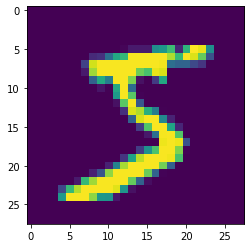

In [7]:
# Here is a visual example of number from the data set

example = training_set[0]
plt.imshow(example[0].numpy().reshape(28,28))

In [8]:
# Using PyTorch's in-built DataLoader function to structure batches for
# training and testing data sets. Dividing the data in this way 
# improves GPU performance

from torchvision import transforms

training_loader=DataLoader(training_set,batch_size=100,shuffle=True)
testing_loader=DataLoader(testing_set,batch_size=100,shuffle=True)



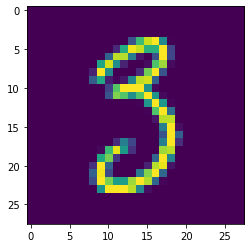

In [9]:
# Another visual example, this time a sample from the batch. Since
# the data is shuffle it should adjust each time this command is run.

plt.imshow(iter(training_loader).next()[0][0].reshape(28,28))

In [10]:
iter(training_loader).next()[0][0].dtype



torch.int64

In [11]:
# Next we generate a neural net to perform the matrix operations on the
# data. First some presets must be configured


# we set this to 1 because the hues are greyscale image
input_size=1
# first convolution converts 1 channel to 16 channels in feature maps
hid1_size=16
# then to 32 channels
hid2_size=32

k_conv_size=5
import torch.nn.functional as F

In [12]:
# Class that defines the neutral net. This has two layers and the 
# forward function defines the process between the two layers to 
# progressively improve the prediction

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1=torch.nn.Sequential(
        torch.nn.Conv2d(input_size,hid1_size,k_conv_size),
        torch.nn.BatchNorm2d(hid1_size),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2)
            
        )
        
        self.layer2=torch.nn.Sequential(
            torch.nn.Conv2d(hid1_size,hid2_size,k_conv_size),
            torch.nn.BatchNorm2d(hid2_size),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.fc=torch.nn.Linear(512,10)
        
        
    def forward(self,x):
        x=self.layer1(x)
        
        x=self.layer2(x)
        # Changing the image into one dimensional tensor for feeding 
        # the fully connected layers
        x=x.reshape(x.shape[0],-1)
       
        x=self.fc(x)
        return x

In [13]:
# Generating the neural net from the GPU you - must be an NVIDIA model

model=Net()
device=torch.device('cuda')
model.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [14]:
# Next we generate the loss function, in this case a Cross Entropy Loss

lr=1e-3
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9)

In [15]:
# Setting the number of epochs for the model to run

epochs=3
loss_values=[]

In [16]:
# Here the pixel hues are converted back to images. I wonder if there
# would be a more direct way to analyse the images?


targets=np.array([])
preds=np.array([])
for epoch in range(epochs):
    for i,(img,target) in enumerate(training_loader):
        img=img.reshape(100,1,28,28).float().to(device)
        optimizer.zero_grad()
        output=model(img)
        pred=torch.argmax(output,axis=1)
#         print(target,pred)
        targets=np.hstack([targets,target.cpu().numpy()])
        preds=np.hstack([preds,pred.cpu().numpy()])
        loss=loss_fn(output,target.to(device))
        
        loss.backward()
        optimizer.step()
        if i % 100==0:
            print(loss)

tensor(2.3850, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4731, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2775, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1814, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1389, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2109, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1198, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0751, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1087, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2166, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0880, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1470, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0666, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1056, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0271, device='cuda:0', grad_fn=<NllLossBackward

In [17]:
from sklearn.metrics import accuracy_score,recall_score

In [18]:
accuracy_score(targets,preds)

0.9510111111111111

In [19]:
recall_score(targets,preds,average='macro')

0.9506141148115714